# Imports

In [1]:
import os
from dqn_agent import DQNAgent
from ppo_agent import PPOAgent
from ffnn_agent import FFNNAgent
from data_processing import load_preprocessed_dataset, get_xy_from_data
from training import train_agents, train_ffnn_baseline, evaluate_ffnn
from visualize import plot_rewards, plot_episode_rewards, plot_cumulative_rewards, plot_mse_hist, plot_female_mse_hist, plot_episode_rewards_combined, plot_cumulative_rewards_combined

# Load Data

In [2]:
# Load the preprocessed dataset
df = load_preprocessed_dataset()
target_features = ["Resting HR", "Max HR", "Age", "Weight", "Height"]

# Split based on Activity ID
df_val = df[df['Activity ID'] == 1].copy()
df_test = df[df['Activity ID'] == 2].copy()
df_train = df[~df['Activity ID'].isin([1, 2])].copy()

# Shuffle train set (optional but recommended)
df_train = df_train.sample(frac=1, random_state=42).reset_index(drop=True)

# Report split sizes
print(f"\nTrain samples (excluding Activity 1 & 2): {df_train.shape[0]}")
print(f"Validation samples (Activity 1): {df_val.shape[0]}")
print(f"Test samples (Activity 2): {df_test.shape[0]}")


---- Preprocessed Dataset Info ----
Number of rows: 61000
Number of columns: 39
-----------------------------------

Train samples (excluding Activity 1 & 2): 47000
Validation samples (Activity 1): 7000
Test samples (Activity 2): 7000


# Initialize system

In [3]:
continuous_columns = [
    'Timestamp',  'Hand Sensor - Temperature',
    'Hand Sensor - Accelerometer - X', 'Hand Sensor - Accelerometer - Y',
    'Hand Sensor - Accelerometer - Z', 'Hand Sensor - Gyroscope - X',
    'Hand Sensor - Gyroscope - Y', 'Hand Sensor - Gyroscope - Z',
    'Hand Sensor - Magnetometer - X', 'Hand Sensor - Magnetometer - Y',
    'Hand Sensor - Magnetometer - Z', 'Chest Sensor - Temperature',
    'Chest Sensor - Accelerometer - X', 'Chest Sensor - Accelerometer - Y',
    'Chest Sensor - Accelerometer - Z', 'Chest Sensor - Gyroscope - X',
    'Chest Sensor - Gyroscope - Y', 'Chest Sensor - Gyroscope - Z',
    'Chest Sensor - Magnetometer - X', 'Chest Sensor - Magnetometer - Y',
    'Chest Sensor - Magnetometer - Z', 'Ankle Sensor - Temperature',
    'Ankle Sensor - Accelerometer - X', 'Ankle Sensor - Accelerometer - Y',
    'Ankle Sensor - Accelerometer - Z', 'Ankle Sensor - Gyroscope - X',
    'Ankle Sensor - Gyroscope - Y', 'Ankle Sensor - Gyroscope - Z',
    'Ankle Sensor - Magnetometer - X', 'Ankle Sensor - Magnetometer - Y',
    'Ankle Sensor - Magnetometer - Z'
]

discrete_columns = [
     'Sex - Female', 'Heart Rate', "Resting HR", "Max HR", "Weight", "Height"
]

#discrete action size columns
dqn_config = {
    'state_size': 5,  
    'action_size': len(discrete_columns),  
    'hidden_size': 64,
    'lr': 1e-2, # HYPERPARAMETER FOR EXPERIMENTS
    'gamma': 0.8, # HYPERPARAMETER FOR EXPERIMENTS
    'batch_size': 64,
    'memory_size': 10000,
    'epsilon_start': 1.0,
    'epsilon_min': 0.01,
    'epsilon_decay': 0.995
}


#continuous
ppo_config = {
    'state_size': 5,  
    'action_size': len(continuous_columns),   
    'hidden_size': 64,
    'lr': 1e-2, # HYPERPARAMETER FOR EXPERIMENTS
    'gamma': 0.8, # HYPERPARAMETER FOR EXPERIMENTS
    'clip_epsilon': 0.2,
    'update_epochs': 10,
    'batch_size': 64,
    'c1': 0.5,
    'c2': 0.01
}
classes = [1, 2, 3, 17, 16, 13, 4, 7, 6]

ffnn_config = { # DO NOT CHANGE THIS CONFIG
    'input_size': df.shape[1] - 5,
    'hidden_sizes': [16, 16],
    'output_size': 5,
    'learning_rate': 0.001,
    'batch_size': 32,
    'epochs': 20,
    'type': 'regression',
    'classes': None
}

accuracy_reward_multiplier = 10
synthetic_data_amount = 1000
num_episodes = 100

experiment_name = "nadine" # CHANGE THIS FOR EACH EXPERIMENT
results_folder = "latest_results" # so that we don't overwrite previous results

dqn_agent = DQNAgent(**dqn_config)
ppo_agent = PPOAgent(**ppo_config)
ffnn_agent = FFNNAgent(**ffnn_config)
ffnn_agent_og = FFNNAgent(**ffnn_config)

Using device: cpu
Using device: cpu


# Training

In [ ]:
# train agents
save_path = os.path.join(results_folder, experiment_name, "metrics")
os.makedirs(save_path, exist_ok=True)

baseline_results = train_ffnn_baseline(
    ffnn_agent_og, df_train, df_val, df_test, target_features,
    save_path, show_loss_plots=False
)

training_results = train_agents(
    df_train, df_val, df_test, target_features,
    dqn_agent, ppo_agent, ffnn_agent, 
    continuous_columns, num_episodes, synthetic_data_amount, accuracy_reward_multiplier, 
    save_path, show_loss_plots=False
)

# save trained models
save_path = os.path.join(results_folder, experiment_name, "saved_models")
os.makedirs(save_path, exist_ok=True)
dqn_agent.save(os.path.join(save_path, "dqn_trained_model.pth"))
ppo_agent.save(os.path.join(save_path, "ppo_trained_model.pth"))

# Testing


In [ ]:
x_test, y_test = get_xy_from_data(df_test, target_features)
mse, mae, female_mse = evaluate_ffnn(ffnn_agent, x_test, y_test)
print("\n========== Trained FFNN Agent Test Results ============")
print(f"MSE: {mse:.4f} | MAE: {mae:.4f} | Female MSE: {female_mse:.4f}")
print("=======================================================\n")

# Visualize results

In [6]:
results_folder_name = "saved_results" # change this to whatever folder the results are saved in

##### Nick's Experiment
##### Hyperparameters: lr=1e-4, gamma=0.9995

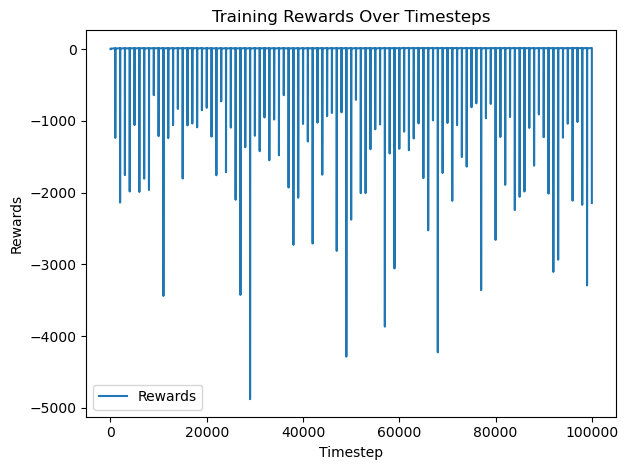

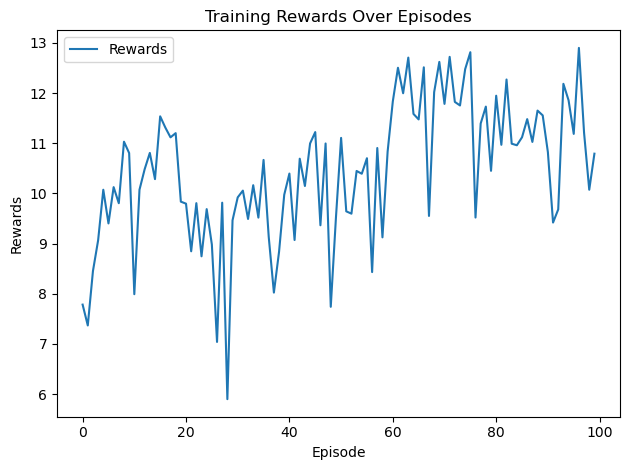

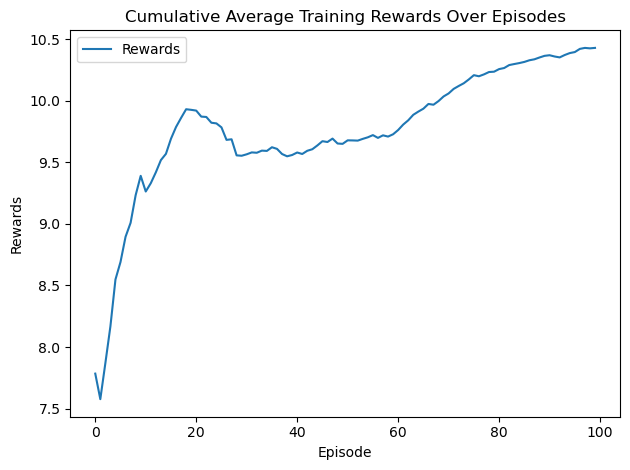

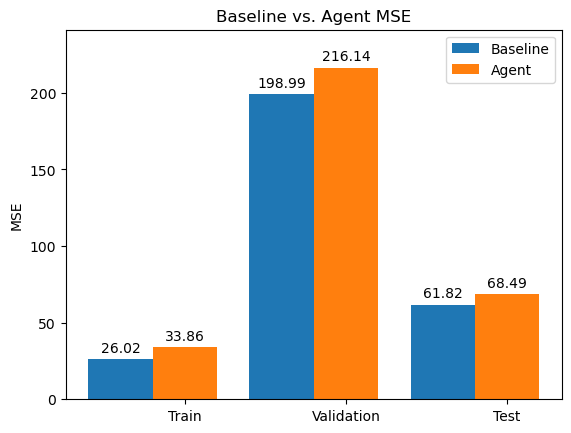

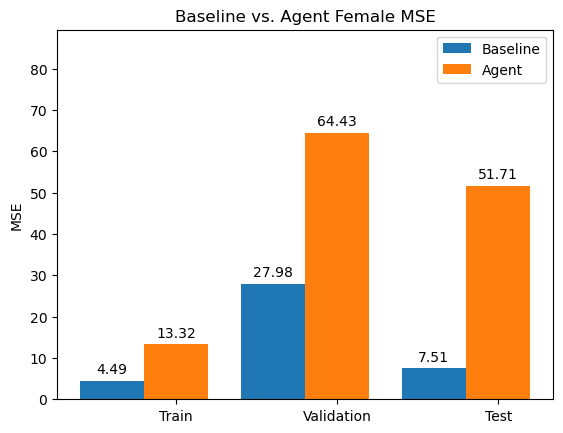

In [7]:
# Plotting Nick's Experiment results
training_metrics_path = os.path.join(results_folder_name, 'nick', 'metrics', 'training_metrics_nick.json')
baseline_metrics_path = os.path.join(results_folder_name, 'nick', 'metrics', 'baseline_metrics_nick.json')
save_path = os.path.join(results_folder_name, 'nick', 'plots')
os.makedirs(save_path, exist_ok=True)

plot_rewards(training_metrics_path, save_path)
plot_episode_rewards(training_metrics_path, save_path)
plot_cumulative_rewards(training_metrics_path, save_path)
plot_mse_hist(baseline_metrics_path, training_metrics_path, save_path)
plot_female_mse_hist(baseline_metrics_path, training_metrics_path, save_path)

##### Ethan's Experiment
##### Hyperparameters: lr=1e-3, gamma=0.99

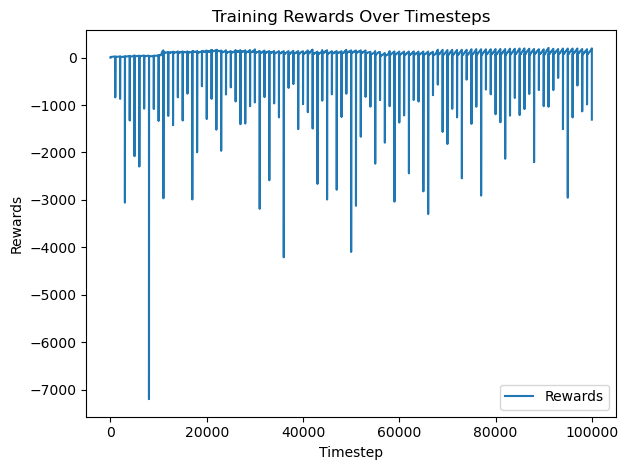

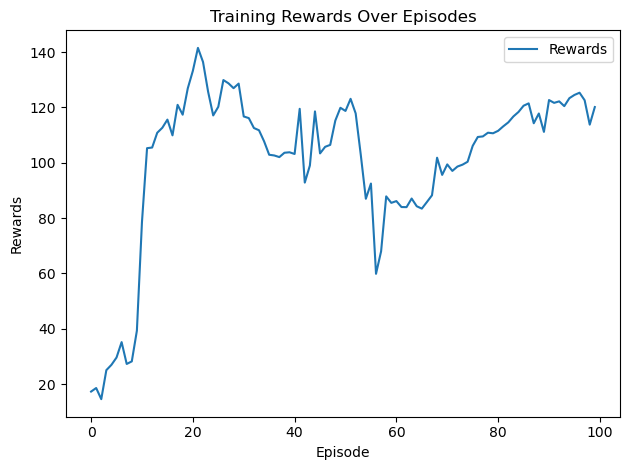

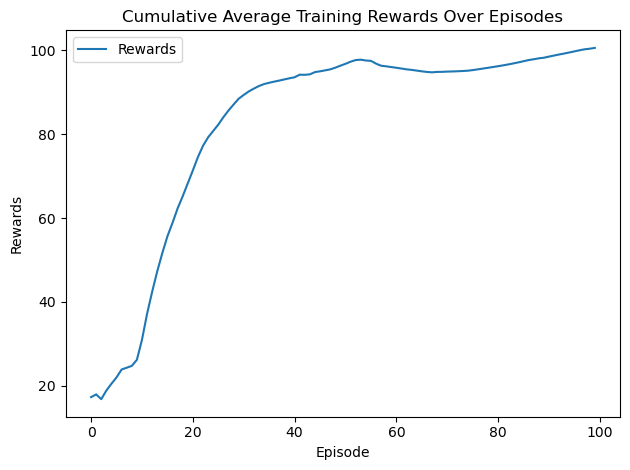

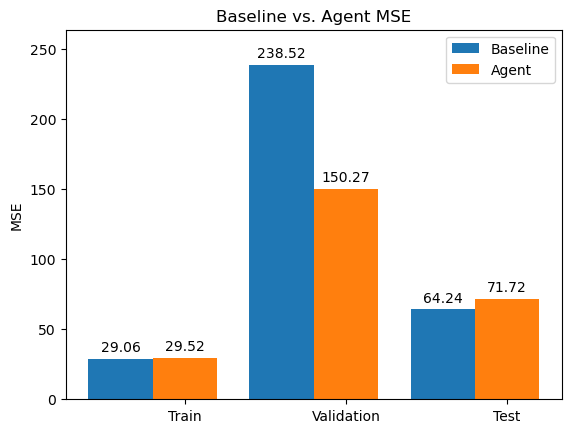

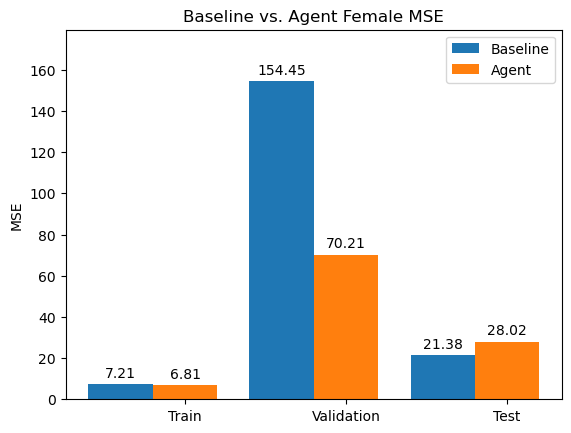

In [8]:
# Plotting Ethan's Experiment results
training_metrics_path = os.path.join(results_folder_name, 'ethan', 'metrics', 'training_metrics_ethan.json')
baseline_metrics_path = os.path.join(results_folder_name, 'ethan', 'metrics', 'baseline_metrics_ethan.json')
save_path = os.path.join(results_folder_name, 'ethan', 'plots')
os.makedirs(save_path, exist_ok=True)

plot_rewards(training_metrics_path, save_path)
plot_episode_rewards(training_metrics_path, save_path)
plot_cumulative_rewards(training_metrics_path, save_path)
plot_mse_hist(baseline_metrics_path, training_metrics_path, save_path)
plot_female_mse_hist(baseline_metrics_path, training_metrics_path, save_path)

##### Nadine's Experiment
##### Hyperparameters: lr=1e-2, gamma=0.8

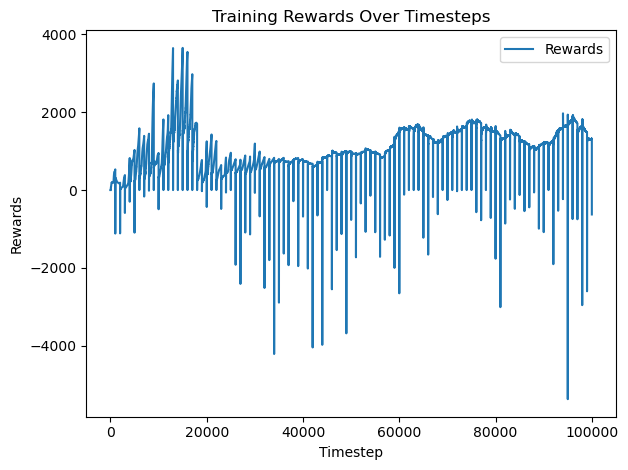

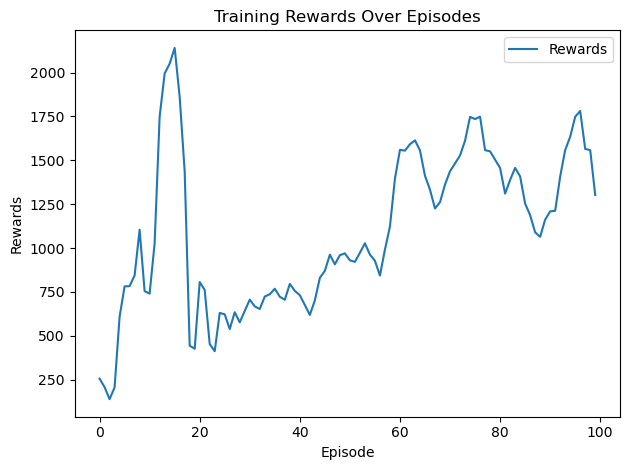

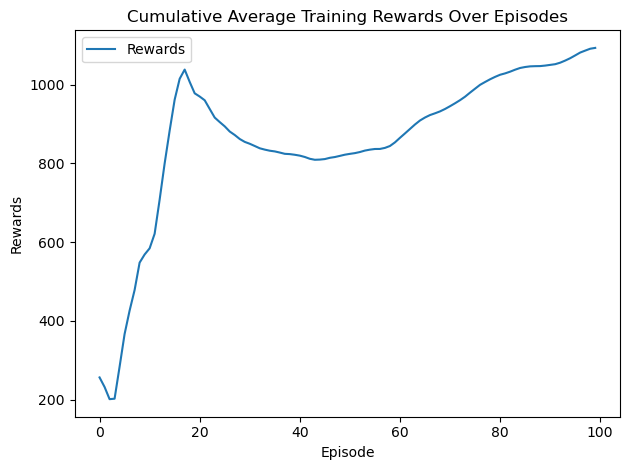

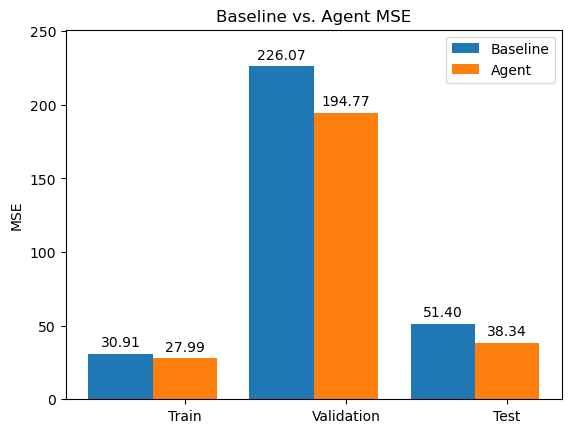

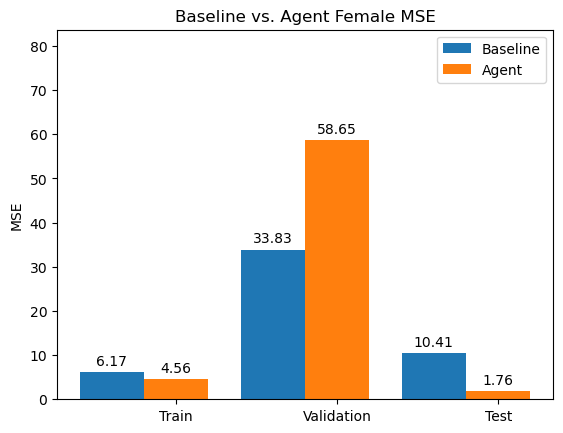

In [9]:
# Plotting Nadine's Experiment results
training_metrics_path = os.path.join(results_folder_name, 'nadine', 'metrics', 'training_metrics_nadine.json')
baseline_metrics_path = os.path.join(results_folder_name, 'nadine', 'metrics', 'baseline_metrics_nadine.json')
save_path = os.path.join(results_folder_name, 'nadine', 'plots')
os.makedirs(save_path, exist_ok=True)

plot_rewards(training_metrics_path, save_path)
plot_episode_rewards(training_metrics_path, save_path)
plot_cumulative_rewards(training_metrics_path, save_path)
plot_mse_hist(baseline_metrics_path, training_metrics_path, save_path)
plot_female_mse_hist(baseline_metrics_path, training_metrics_path, save_path)

##### Plotting Combined Reward Plots

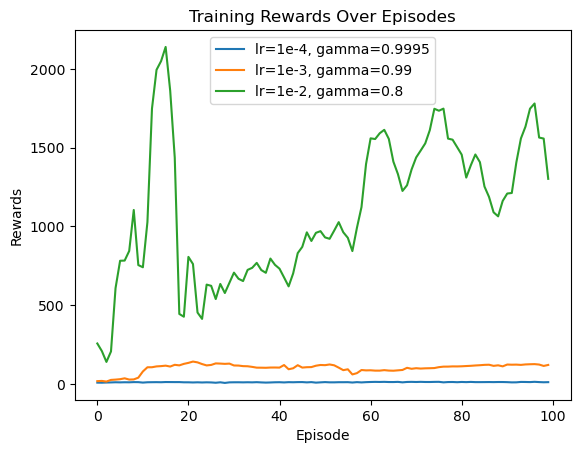

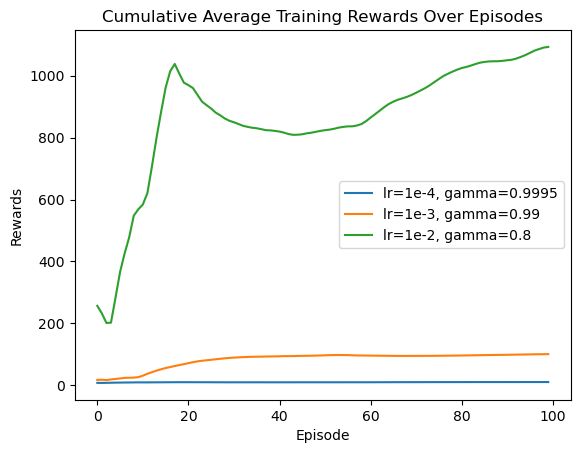

In [10]:
# Plotting combined results for all experiments
metrics_path_list = [
    os.path.join(results_folder_name, 'nick', 'metrics', 'training_metrics_nick.json'), 
    os.path.join(results_folder_name, 'ethan', 'metrics', 'training_metrics_ethan.json'), 
    os.path.join(results_folder_name, 'nadine', 'metrics', 'training_metrics_nadine.json')
]
experiment_hyperparams_list = [
    'lr=1e-4, gamma=0.9995',
    'lr=1e-3, gamma=0.99',
    'lr=1e-2, gamma=0.8'
]
save_path = os.path.join(results_folder_name, 'comparison_plots')
os.makedirs(save_path, exist_ok=True)

plot_episode_rewards_combined(metrics_path_list, experiment_hyperparams_list, save_path)
plot_cumulative_rewards_combined(metrics_path_list, experiment_hyperparams_list, save_path)